In [1]:
import numpy as np
import matplotlib.pyplot as plt
import model
import plot_tools
import clock_work_axion
import reheating
import transport_equation
from common import constants, cosmology

In [2]:
Gamma_phi = 1e7
H_inf = 2e10
mR = 6
m_phi = 100 * 1e-9 # [GeV]
eps = clock_work_axion.calc_eps(mR)
f = 1e12
f_eff = clock_work_axion.calc_f_eff(f, eps)
t0, initial = reheating.calc_initial_reheating(H_inf)
tf = t0*1e7
M = m_phi / eps
params = (mR, M)
T_osc = (90 * constants.M_pl**2 * m_phi**2 / (constants.g_star * np.pi**2))**(1/4)

In [3]:
%time T_fn, H_fn, T_dot_fn, final = reheating.solve_reheating_eq(t0, tf, initial, Gamma_phi)

CPU times: user 3.37 ms, sys: 3.98 ms, total: 7.35 ms
Wall time: 28.6 ms


In [4]:
m = model.AxionBaryogenesisModel(
    source_vector=transport_equation.source_vector_weak_sphaleron, 
    get_axion_source=clock_work_axion.get_axion_source_clockwork,
    axion_rhs=clock_work_axion.rhs_log_t,
    calc_axion_mass=clock_work_axion.calc_mass,
    axion_parameter=(eps, M),
    axion_initial=(clock_work_axion.theta_to_phi_over_f(1.0, eps), 0),
    Gamma_phi=Gamma_phi,
    H_inf=H_inf,
)

/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:60: RuntimeWarning: overflow encountered in exp
  t = np.exp(log_t)
/home/jana/Documents/master-project/transport_eq_in_time/plot_tools.py:29: RuntimeWarning: invalid value encountered in true_divide
  y = theta_dot / T / source_scale


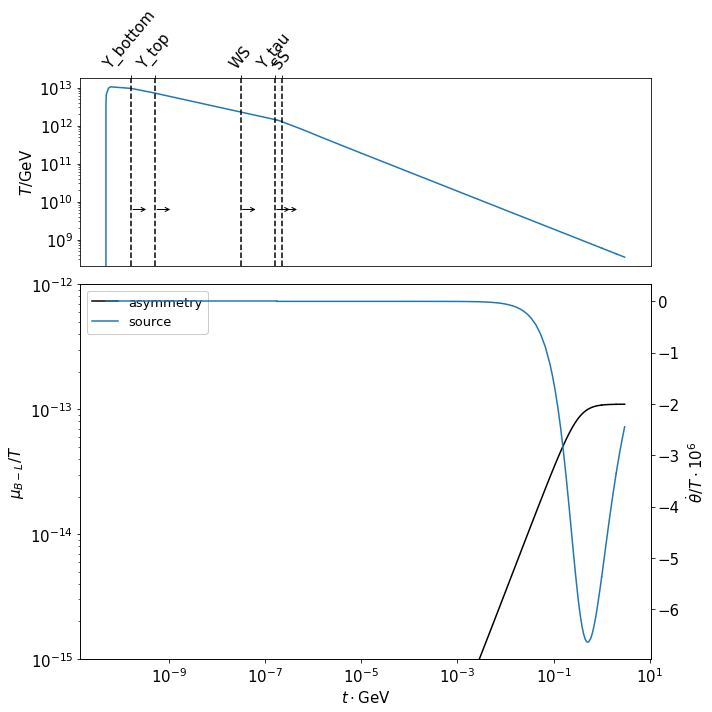

In [5]:
res = model.solve(m, collect=True)
plot_tools.plot(res, asymmetry_limits=(1e-15, 1e-12), source_scale=1e-9)

In [6]:
_B_minus_L_red_chem, T_final, axion_final = model.solve(m)

/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:60: RuntimeWarning: overflow encountered in exp
  t = np.exp(log_t)


In [7]:
t_final = cosmology.switch_hubble_and_time_rad_dom(cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(T_final)))

change: 3.6145107860086116 Y: 0.38248073228515117 convergence_eps: 0.01
change: 0.0005183638219559354 Y: 0.38228257083066824 convergence_eps: 0.01


10.489175505145681

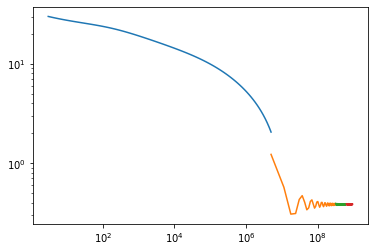

In [8]:
clock_work_axion.compute_relic_density(axion_final, T_final, t_final, f, mR, M, debug=True)

In [9]:
t_osc = cosmology.switch_hubble_and_time_rad_dom(cosmology.calc_hubble_parameter(cosmology.calc_entropy_density(T_osc)))

In [10]:
"%e %e" % (t_final, t_osc)

'3.000000e+00 2.236517e+09'

Text(0, 0.5, 'V_eff / GeV^4')

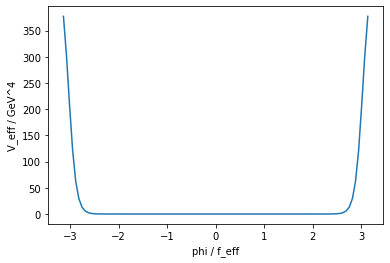

In [11]:
theta_range = np.linspace(-np.pi, np.pi, 100)
phi_over_f_range = f_eff * theta_range / f # not a linear map
plt.plot(theta_range, clock_work_axion.calc_V_eff_over_f_sq(phi_over_f_range, eps, M))
plt.xlabel("phi / f_eff")
plt.ylabel("V_eff / GeV^4")

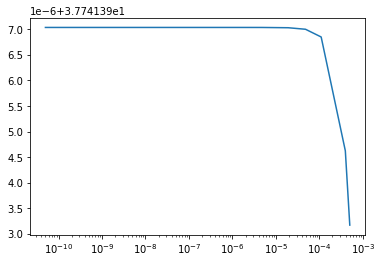

In [12]:
T_fn_rad_dom, H_fn_rad_dom = cosmology.make_rad_dom_H_fn(tf, T_fn(tf))
sol_sbg = clock_work_axion.evolve(t0, tf, (clock_work_axion.theta_to_phi_over_f(1.0, eps), 0), (eps, M, H_fn))
plt.semilogx(sol_sbg.t, sol_sbg.y[0])

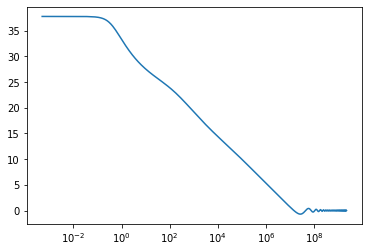

In [13]:
sol_relic = clock_work_axion.evolve(tf, t_osc, sol_sbg.y[:, -1], (eps, M, H_fn_rad_dom))
plt.semilogx(sol_relic.t, sol_relic.y[0])

Text(0, 0.5, 'Y')

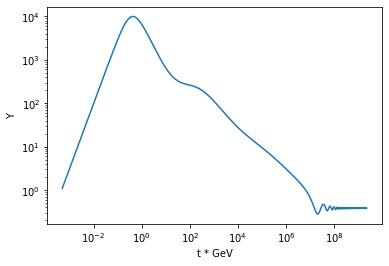

In [14]:
Y = clock_work_axion.calc_abundance(*sol_relic.y, T_fn_rad_dom(sol_relic.t), eps, mR, f, M)
plt.loglog(sol_relic.t, Y)
plt.xlabel("t * GeV")
plt.ylabel("Y")

In [15]:
clock_work_axion.compute_relic_density(sol_sbg.y[:, -1], T_fn(sol_sbg.t[-1]), sol_sbg.t[-1], f, mR, M)

10.488567118860674

In [17]:
N = 10
m_phi_range = np.geomspace(1e-5, 1e5, N) * 1e-9 # [GeV]
mR_range = np.linspace(0, 15, N)[1:]
f_eff = 1e13 # GeV

In [ ]:
H_inf = 1e8
Gamma_phi = H_inf
%time obs = np.array([[clock_work_axion.compute_observables(m_phi, mR, f_eff, Gamma_phi, H_inf) for m_phi in m_phi_range] for mR in mR_range])

In [ ]:
A = np.log10(obs[:, :, 0] / constants.eta_B_observed)
level = np.sort(np.concatenate([[0], np.arange(np.nanmin(A), np.nanmax(A), 4)]))
C1 = plt.contour(m_phi_range * 1e9, mR_range, A, levels=level, cmap="viridis")
C1.collections[np.where(C1.levels == 0)[0][0]].set_color("black")
C1.collections[np.where(C1.levels == 0)[0][0]].set_linewidths(2)
plt.colorbar().set_label(r"$\log_{10} ( \eta_B / \eta_B^{\mathrm{obs}})$")

B = np.log10(obs[:, :, 1] / constants.Omega_DM_h_sq)
level = np.sort(np.concatenate([[0], np.arange(np.nanmin(B), np.nanmax(B), 4)]))
C2 = plt.contour(m_phi_range * 1e9, mR_range, B, levels=level) # , cmap="plasma")
#C2.collections[np.where(C2.levels == 0)[0][0]].set_linewidths(5)
#C2.collections[np.where(C2.levels == 0)[0][0]].set_color("black")
plt.colorbar().set_label(r"$\log_{10} ( \eta_B / \eta_B^{\mathrm{obs}})$")

plt.xlabel("$m_\phi$ / eV")
plt.ylabel("mR")
plt.xscale("log")
plt.tight_layout()

In [ ]:
plt.pcolormesh(m_phi_range * 1e9, mR_range, np.log(obs[:,:,1]))
plt.xscale("log")
plt.colorbar()